<a href="https://colab.research.google.com/github/PadmajaVB/AttentioNet/blob/main/AttentioNet_TeamDropouts_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AttentioNet
> Grasping the attention of your audience with CNN's

<p><img src="https://www.incimages.com/uploaded_files/image/1920x1080/audience-pano_22824.jpg" width="1000" height="700"></a><br><a href="https://www.incimages.com/uploaded_files/image/1920x1080/audience-pano_22824.jpg">Image Source</a></p>

# Introduction

Adapting to the new age that we now live in can sometimes be difficult, especially so for individuals who's work depends on the response of an audience. Considering this, [Manisha](https://github.com/Manisha2297), [Padmaja](https://www.linkedin.com/in/padmajavb/), [Vipul](https://github.com/vipultanwr) and [Niegil](https://github.com/Niegil-Francis) came up with an innovative approach to resolve this using CNN's, as a part of their final project for [A1C2](https://www.univ.ai/programs#ai).

The inception of the idea came from a simple thought. What if we were able to get a live feedback of an audience to know whether the content we deliver is as effective as it can be? This along with consideration to the digital world we now live in, gave us our motivation to create a model that is able to capture screenshots a video stream and give you a live feedback of the attentivity of your audience.

Without further ado, let's take you through our implementation.

# Gathering resources

After a long search, we fell upon a data set provided by [University of Texas at Arlington](https://sites.google.com/view/utarldd/home), which consists of 180 videos, each of which were 10 minutes long. They were labelled into three classes:<br>
-alert (0)<br> 
-low vigilant (5)<br>
-drowsy (10) <br>
All of which were labelled by the participants themselves. For our purpose, we used just classes alert and drowsy to indicate attentiveness.

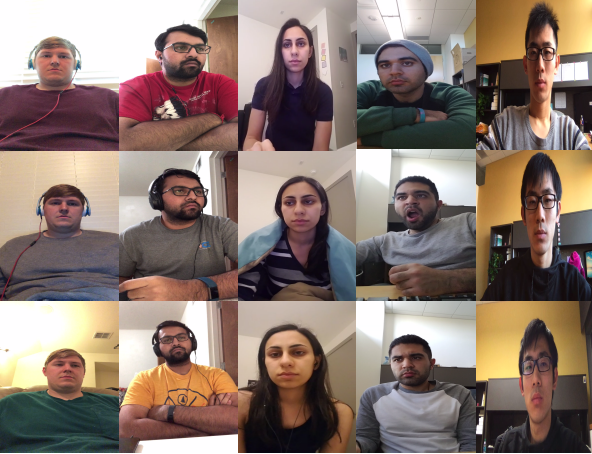

There is a well thought of [implementation](https://towardsdatascience.com/drowsiness-detection-with-machine-learning-765a16ca208a) using face features extracted with [HOG](https://www.learnopencv.com/histogram-of-oriented-gradients/) (Histograms of Gradients) which is then run through an algorithm that gives the mouth to eye ratio. Based on this ratio, the person is estimated to be either drowsy, not drowsy or intermediate. Their conclusion however, was drawn from mouth to eye ratio features fed into their model. We decided against this approach, our argument being that if a person blinks while talking, he shouldn't be considered as sleepy. We thus, instead feed the image itself overlapped with the face features extracted into our CNN.

Note: Please change the folder paths as necessary to run code. (drowsiness folder to data wherever applicable) 

# Pre-processing of data

#### Importing the required libraries

In [ ]:
#mount your own drive to avoid downloading the data multiple time 
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# installing the required libraries
!pip -qq install tf_keras_vis
!pip install mlextend
!pip install opencv-python

In [ ]:
%%capture
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil
import sys
import time
from glob import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from glob import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from mlxtend.image import extract_face_landmarks
from PIL import Image
import tensorflow as tf
from scipy.spatial import distance
import cv2
import os
import tqdm
from tf_keras_vis.gradcam import Gradcam 
from tf_keras_vis.utils import normalize
import warnings
from keras.models import Model

import matplotlib.dates as mdates
from mlxtend.image import extract_face_landmarks
from matplotlib import cm

warnings.filterwarnings("ignore")


#### Defining the required functions to calculate mouth over eye aspect ratio

In [ ]:


# Based on the implementation given before
def eye_aspect_ratio(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear
def mouth_aspect_ratio(mouth):
    A = distance.euclidean(mouth[14], mouth[18])
    C = distance.euclidean(mouth[12], mouth[16])
    mar = (A ) / (C)
    return mar
def mouth_over_eye(eye):
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(eye)
    mouth_eye = mar/ear
    return mouth_eye
def getFrame(sec):
    start = 180000
    vidcap.set(cv2.CAP_PROP_POS_MSEC, start + sec*1000)
    hasFrames,image = vidcap.read()
    return hasFrames, image

#### Extracting face features and storing images
Here we extract images from the video by checking if face features are detected. This is done in order to remove images that are not clear or faces are absent. After this we calculate the mouth to eye aspect ratio, where we are taking outliers i.e. images where the person has blinked and images where the eyes are wide open belonging to the same class (This corresponds to the top 10 and bottom 10 percentile of mouth to eye ratio). This was done in order to force our model to look at other features apart from eyes and mouth to distinguish between the two classes (eg: posture). The mouth over eye aspect ratio was taken one subject at a time in order to avoid different thresholds due to the differences in face structures for different ethnicities.

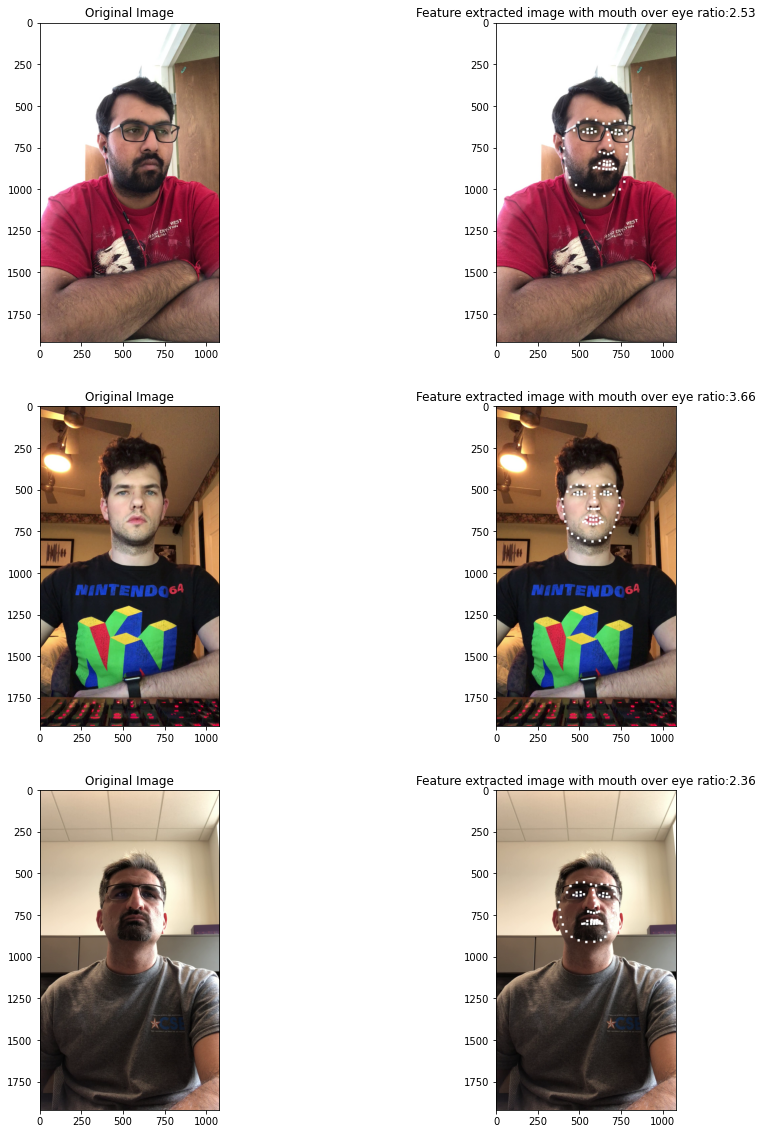

In [ ]:

#For labelling of images
img_cnt_0=0
img_cnt_10=0


# For plottting images
counter=0

fig = plt.figure(figsize=(15, 20))

# Picking out the folders belonging to each subject within a main folder
for j in range(1,4):
    cnt_plt=0
    if j<10:
        fol_num=str(0)+str(j)
    else:
        fol_num=str(j)
        
    folder_path = '/content/gdrive/MyDrive/drowsiness/Fold1_part1/' + str(fol_num) + '/'
    
    # Finding the video files in the specified path
    video_files = os.listdir(folder_path)
    
    
    for file in video_files:
        data = []
        labels = []
        images = []
        fname = file.split(".")[0]
        if fname == '5':
            continue
        ext = file.split(".")[-1]

        vidcap = cv2.VideoCapture('/content/gdrive/MyDrive/drowsiness/Fold1_part1/' + str(fol_num) +'/' + file)
        sec = 0
        frameRate = 1.5
        success, image = getFrame(sec)
        count = 0
        while success:
            rot_count=0
            
            #images are rotated to see if after rotation landmarks are captured
            while np.sum(extract_face_landmarks(image))==0.0:
                image=cv2.rotate(image, cv2.cv2.ROTATE_90_CLOCKWISE)
                rot_count+=1
                if(rot_count==4):
                    break
                
            landmarks = extract_face_landmarks(image)
            
            
            # Comment the code here to remove plotting
            if cnt_plt<1 and np.sum(landmarks)!=0:
                eye = landmarks[36:68]
                ear = eye_aspect_ratio(eye)
                mar = mouth_aspect_ratio(eye)
                mouth_eye = mouth_over_eye(eye)
                
                # Creating a copy for plotting
                img_cpy=image
                ax1 = fig.add_subplot(3, 2, counter*2+1)
                ax1.imshow(cv2.cvtColor(img_cpy, cv2.COLOR_BGR2RGB))
                ax1.title.set_text("Original Image")

                for p in landmarks:
                    img_cpy[p[1]-7:p[1]+7, p[0]-7:p[0]+7, :] = (255, 255, 255)
                ax2 = fig.add_subplot(3, 2, counter*2+2)
                ax2.imshow(cv2.cvtColor(img_cpy, cv2.COLOR_BGR2RGB))
                ax2.title.set_text("Feature extracted image with mouth over eye ratio:"+str(round(mouth_eye,2)))

                #Comment the below two lines while generating images to be stored
                cnt_plt+=1
                counter+=1
                

            #Comment the below two lines while generating images to be stored 
            if cnt_plt>=1:
                break

                
            if np.sum(landmarks)!= 0:
                count += 1
                data.append(landmarks)
                labels.append([int(file.split(".")[0])])
                sec = sec + frameRate
                sec = round(sec, 2)
                images.append(image)
                success, image = getFrame(sec)
                
            else:
                sec = sec + frameRate
                sec = round(sec, 2)
                success, image = getFrame(sec)

        #Comment the below two lines while generating images to be stored
        if cnt_plt>=1:
          continue

          

        data = np.array(data)
        labels = np.array(labels)
        mouth_eye_ratios = []
        for d in data:
            eye = d[36:68]
            ear = eye_aspect_ratio(eye)
            mar = mouth_aspect_ratio(eye)
            mouth_eye = mouth_over_eye(eye)
            mouth_eye_ratios.append(mouth_eye)


        # Getting the outlier images for each subject 
        CI = (np.percentile(mouth_eye_ratios,10),np.percentile(mouth_eye_ratios,90))
        for i,ratio in enumerate(mouth_eye_ratios):
            if(ratio>CI[1] or ratio<CI[0]):
            
                if labels[i] == 0:
                    #uncomment to write data into the folders
                    #cv2.imwrite("./data/drowsiness/drowsy/frame_fol2%d.jpg" % img_cnt_0, images[i])
                    img_cnt_0+=1
                else:
                    #uncomment to write data into the folders
                    #cv2.imwrite("./data/drowsiness/not_drowsy/frame_fol2%d.jpg" % img_cnt_10, images[i])
                    img_cnt_10+=1
                    
plt.show();

Shown above is a depiction of the feature extraction used to find the mouth over eye aspect ratio. Here we can see that the its very subject dependent, based on the structure of the resting face. 

#### Loading the dataset
We divided the training into two folders drowsy and alert to be fed into datagen. <br>
The test data is got from individuals which the model has not seen to be able to test our models generalizability.


In [ ]:
data_dir = '/content/gdrive/MyDrive/drowsiness/data'


data_train='/content/gdrive/MyDrive/AI-2 Project: Dropouts/data/train'
data_validation='/content/gdrive/MyDrive/AI-2 Project: Dropouts/data/validation'
data_test='/content/gdrive/MyDrive/AI-2 Project: Dropouts/data/unseen/'

drowsy_data_dir = '/content/gdrive/MyDrive/drowsiness/data/drowsiness/drowsy/'
alert_data_dir = '/content/gdrive/MyDrive/drowsiness/data/drowsiness/alert/'

Splitting our training data into train and validation folders 

In [ ]:
# uncomment and run if folders are empty

# copy dataset images into subdirectories based on probability distribution 'p'
# np.random.seed(42)
# for file in os.listdir(drowsy_data_dir):
#     dst_dir = np.random.choice(['train', 'validation'], p=[.9, .1])
#     src =  os.path.join(drowsy_data_dir, file)
#     dst = os.path.join(data_dir, dst_dir, 'drowsy', file)
#     try:
#         shutil.copy(src, dst)
#     except Exception as e:
#         print(e)

In [ ]:
# uncomment and run if folders are empty
# np.random.seed(42)
# for file in os.listdir(alert_data_dir):
#     dst_dir = np.random.choice(['train', 'validation'], p=[.9,.1])
#     src =  os.path.join(alert_data_dir, file)
#     dst = os.path.join(data_dir, dst_dir, 'alert', file)
#     try:
#         shutil.copy(src, dst)
#     except Exception as e:
#         print(e)

The preprocessing function takes in the images, rotates it until it's able to detect face landmarks and runs it through a resizer that crops out only the face using the cascade classifier. We noticed that both the face landmarks detector and the cascade classifier is sometimes not able to detect the face clearly. This allowed for variety in our dataset (preventing overfitting). Some of the images didn't have landmarks, some weren't resized and some others were rotated. Most of the drowsy videos were taken at night, using yellow light. To have our model unbiased towards this, we converted the images to grayscale.

In [ ]:
def prep(img):

  image=np.array(img,dtype='uint8')

  rot_count=0
  while np.sum(extract_face_landmarks(image))==0.0:
    image=cv2.rotate(image, cv2.cv2.ROTATE_90_CLOCKWISE)
    rot_count+=1
    if(rot_count==4):
        break    

  landmarks=extract_face_landmarks(image)
  if np.sum(landmarks)!=0:
    
    for p in landmarks:
        image[p[1]-1:p[1]+1, p[0]-1:p[0]+1] = 255

  while rot_count>0:
      image=cv2.rotate(image, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
      rot_count-=1
  
  
  faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
  faces = faceCascade.detectMultiScale(image,scaleFactor=1.3, minNeighbors=3 )
  
  if len(faces)==0 :
    image=image
  else:
    (x,y,w,h)=faces[0]
    image = image[y:y+h, x:x+w]
  
  image=np.array(image, dtype='float64')
  image=cv2.resize(image,(256,256))
  image=image.reshape((256,256,1))
  
  
  return image

In [ ]:
train_data_gen = ImageDataGenerator(rescale=1./255,preprocessing_function=prep)
val_data_gen = ImageDataGenerator(rescale=1./255,preprocessing_function=prep)
test_data_gen = ImageDataGenerator(rescale=1./255,preprocessing_function=prep)

In [ ]:
train_generator = train_data_gen.flow_from_directory(
        data_train,
        batch_size=32,
        shuffle=True,color_mode='grayscale')

val_generator = val_data_gen.flow_from_directory(
        data_validation,
        batch_size=32,
        shuffle=True,color_mode='grayscale')

test_generator = test_data_gen.flow_from_directory(
        data_test,
        batch_size=32,
        shuffle=False,color_mode='grayscale')

Found 4803 images belonging to 2 classes.
Found 515 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


Let's have a look at the pre-processed images

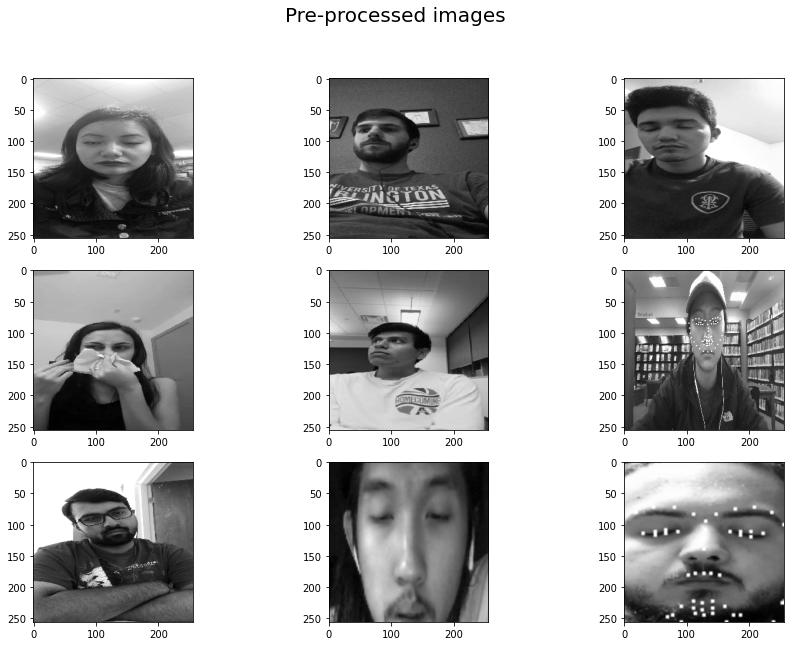

In [ ]:
x= train_generator.next()
fig = plt.figure(figsize=(15, 10))

for batch in x:
    counter=0
    for image in batch:
      ax1 = fig.add_subplot(3, 3, counter+1)
      ax1.imshow(image.reshape(256,256)/255.,cmap='gray')
      counter+=1
      if(counter==9):
        break  
    break
fig.suptitle("Pre-processed images",fontsize=20);

Here we see that the model is fed a variety of images. Some with the face landmarks, some without, some resized and a few rotated. If we re-run the code snippet, we will be able to traverse through our training data to see the different kinds of images.

# Model Architecture and Training

#### Giving the parameters for the model.

In [ ]:
num_features=64
width=256
height=256
step_size_train=train_generator.n//train_generator.batch_size
step_size_validation=val_generator.n//val_generator.batch_size

#### Model architecture

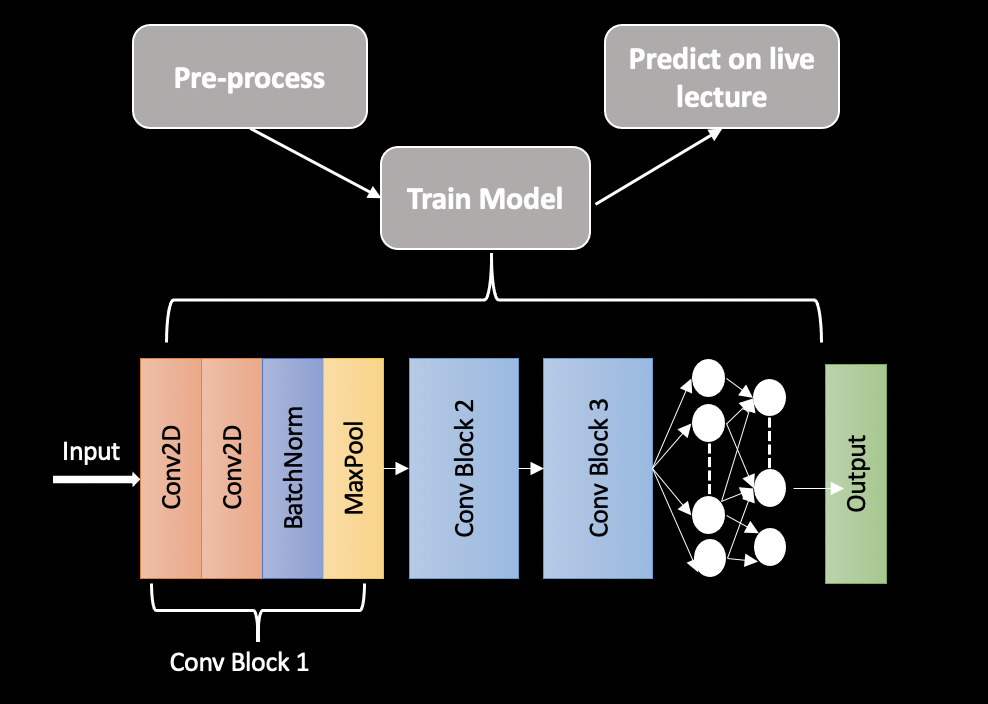

In [ ]:
def create_cnn_model():
  model2 = Sequential()
  model2.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), kernel_regularizer=regularizers.l2(0.01)))
  model2.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model2.add(BatchNormalization())
  model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model2.add(Dropout(0.5))

  model2.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model2.add(BatchNormalization())
  model2.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model2.add(BatchNormalization())
  model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model2.add(Dropout(0.5))

  model2.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model2.add(BatchNormalization())
  model2.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
  model2.add(BatchNormalization())
  model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  model2.add(Dropout(0.5))
  model2.add(Flatten())

  model2.add(Dense(2*num_features, activation='relu'))
  model2.add(Dropout(0.4))
  model2.add(Dense(num_features, activation='relu'))
  model2.add(Dropout(0.5))
  model2.add(Dense(2, activation='softmax'))
  return model2
create_cnn_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 254, 254, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 127, 127, 128)     73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 127, 127, 128)     5

#### Training our model

In [ ]:
# Invoking a model with the above architecture
model= create_cnn_model()

In [ ]:
#Compiling the model
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics='accuracy')

early_callback = EarlyStopping(monitor='loss', patience=5)

history = model.fit(train_generator, validation_data=val_generator, epochs=20,  steps_per_epoch=step_size_train, validation_steps=step_size_validation, callbacks=[early_callback])

Epoch 1/20
150/150 [==============================] - 2133s 14s/step - loss: 13.0883 - accuracy: 0.6414 - val_loss: 2.6147 - val_accuracy: 0.5117
Epoch 2/20
150/150 [==============================] - 1098s 7s/step - loss: 3.3464 - accuracy: 0.7154 - val_loss: 1.0771 - val_accuracy: 0.6211
Epoch 3/20
150/150 [==============================] - 1072s 7s/step - loss: 1.1697 - accuracy: 0.7462 - val_loss: 0.4720 - val_accuracy: 0.8262
Epoch 4/20
150/150 [==============================] - 1059s 7s/step - loss: 0.7019 - accuracy: 0.7724 - val_loss: 0.3258 - val_accuracy: 0.8809
Epoch 5/20
150/150 [==============================] - 1037s 7s/step - loss: 0.5913 - accuracy: 0.8059 - val_loss: 0.4150 - val_accuracy: 0.8203
Epoch 6/20
150/150 [==============================] - 1013s 7s/step - loss: 0.5100 - accuracy: 0.8229 - val_loss: 0.2562 - val_accuracy: 0.9082
Epoch 7/20
150/150 [==============================] - 993s 7s/step - loss: 0.4527 - accuracy: 0.8457 - val_loss: 0.3623 - val_accuracy

#### Plotting the model accuracy and loss for both training and validation

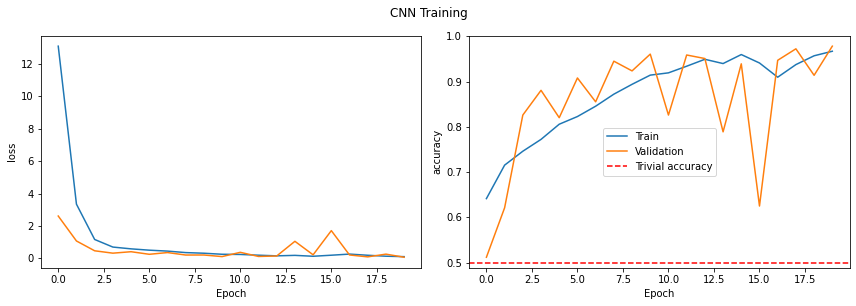

In [ ]:
def plot_history(history, name):
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    for i, metric in enumerate(['loss', 'accuracy']): 
        ax[i].plot(history.history[metric], label='Train')
        ax[i].plot(history.history['val_'+metric], label='Validation')
        if metric == 'accuracy': ax[i].axhline(0.5, c='r', ls='--', label='Trivial accuracy')
        ax[i].set_xlabel('Epoch')
        ax[i].set_ylabel(metric)
    plt.suptitle(f'{name} Training', y=1.05)
    plt.legend()
    plt.tight_layout()

plot_history(history, 'CNN')

#### Saving our model

In [ ]:
model.save('/content/gdrive/MyDrive/AI-2 Project: Dropouts/final')

# Model evaluation

#### Loading our saved model.

In [ ]:
new_model = tf.keras.models.load_model('/content/gdrive/MyDrive/AI-2 Project: Dropouts/final')

#### Testing our model on unseen data.

In [ ]:
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size
model.evaluate(test_generator, steps=STEP_SIZE_TEST)

18/18 [==============================] - 123s 7s/step - loss: 1.8087 - accuracy: 0.6753


[1.8086798191070557, 0.6753472089767456]

Our model is able to perform fairly well on unseen data, with an accuracy of 67.53%. This proves the effectiveness of our approach.

#### Feature maps and saliency graph 

Defining get_feature_maps to get the feature map of a particular layer

In [ ]:
def get_feature_maps(model, layer_id, input_image):
    """Returns intermediate output (activation map) from passing an image to the model
    
    Parameters:
        model (tf.keras.Model): Model to examine
        layer_id (int): Which layer's (from zero) output to return
        input_image (ndarray): The input image
    Returns:
        maps (List[ndarray]): Feature map stack output by the specified layer
    """
    model_ = Model(inputs=[model.input], outputs=[model.layers[layer_id].output])
  
    return model_.predict(input_image)

Using datagen to load a test data batch. This is done in order to get the pre-processed image directly. One image out of this batch is used to plot the feature maps.

In [ ]:
x=test_generator.next()

In [ ]:
for image in x:
  feature_maps = get_feature_maps(new_model, 14, image[0].reshape(1,256,256,1))[0:9]
  break

#### Plotting feature maps

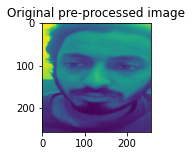

Text(0.5, 0.98, 'Feature maps of the 14th layer (Last convolution layer)')

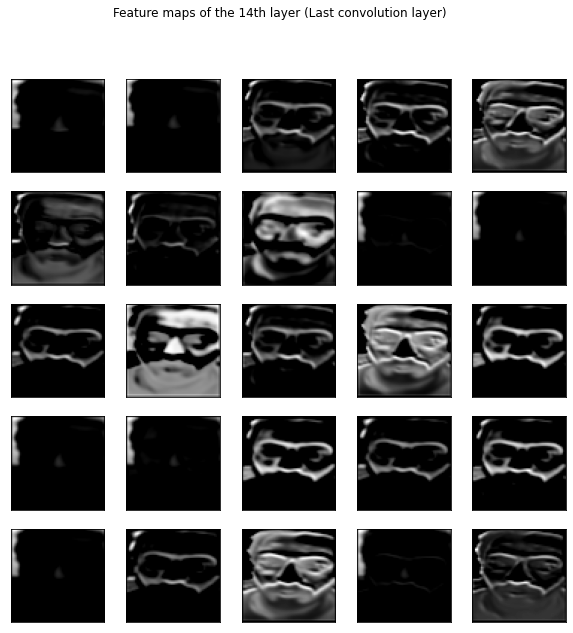

In [ ]:
fig=plt.figure(figsize=(2,2))
plt.imshow(image[0].reshape(256,256))
plt.title('Original pre-processed image')
plt.show()

fig = plt.figure(figsize=(10, 10))
square = 5
index = 1
for _ in range(square):
	for _ in range(square):
        
		ax = fig.add_subplot(square, square, index)
		ax.set_xticks([])
		ax.set_yticks([])

		ax.imshow(feature_maps[0, :, :, index-1]/255., cmap='gray')
  
		index += 1
        
fig.suptitle("Feature maps of the 14th layer (Last convolution layer)")

#### Plotting the saliency graph

Using datagen again to get another batch of data

In [ ]:
x,y=test_generator.next()

Getting the images from the batch

Defining the functions required for the saliency map

In [ ]:
def loss_class0(output):
  return output[0][0]

def loss_class1(output):
  return output[0][1]
  
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m

Creating gradcam for each class 

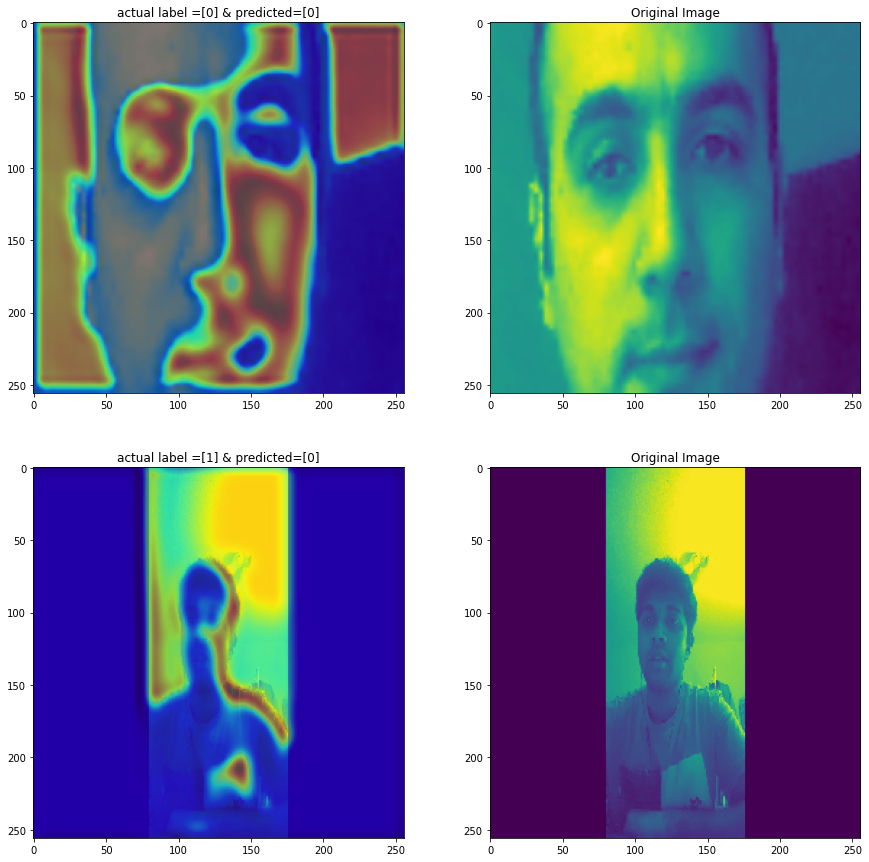

In [ ]:
#GradCAM
# Create Gradcam object
gradcam = Gradcam(new_model,
                model_modifier=model_modifier,
              clone=False)
fig, ax=plt.subplots(2,2,figsize=(15,15))


# Generate heatmap with GradCAM for output class 0 (alert)
cam_1 = gradcam(loss_class0,
              x[0],
              penultimate_layer=-1, # model.layers number
            )
cam_1 = normalize(cam_1)


# Render
heatmap = np.uint8(cm.jet(cam_1[0])[..., :3] * 255)
ax[0,0].set_title(f'actual label ={np.where(y[0]==1)[0]} & predicted={model.predict_classes(x[0].reshape(1,256,256,1))}')
ax[0,0].imshow(x[0].reshape(256,256))
ax[0,0].imshow(heatmap, cmap='jet', alpha=0.5)



# Generate heatmap with GradCAM for output class 1 (drowsy)
cam_2 = gradcam(loss_class1,
              x[1],
              penultimate_layer=-1, # model.layers number
            )
cam_2 = normalize(cam_2)

        
# Render
heatmap = np.uint8(cm.jet(cam_2[0])[..., :3] * 255)
ax[1,0].set_title(f'actual label ={np.where(y[1]==1)[0]} & predicted={model.predict_classes(x[1].reshape(1,256,256,1))}')
ax[1,0].imshow(x[1].reshape(256,256))
ax[1,0].imshow(heatmap, cmap='jet', alpha=0.5)

ax[0,1].imshow(x[0].reshape(256,256))
ax[0,1].set_title('Original Image')
ax[1,1].imshow(x[1].reshape(256,256))
ax[1,1].set_title('Original Image')

plt.show()

# **Application**

## Application 1: Post lecture analysis of classroom mood using AttentioNet
We are using a recorded video of a lecture's zoom gallary view

In [ ]:
def prep(img):

  image=np.array(img,dtype='uint8')

  rot_count=0
  while np.sum(extract_face_landmarks(image))==0.0:
    image=cv2.rotate(image, cv2.cv2.ROTATE_90_CLOCKWISE)
    rot_count+=1
    if(rot_count==4):
        break    

  landmarks=extract_face_landmarks(image)
  if np.sum(landmarks)!=0:
    
    for p in landmarks:
        image[p[1]-1:p[1]+1, p[0]-1:p[0]+1] = 255

  while rot_count>0:
      image=cv2.rotate(image, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)
      rot_count-=1
  
  image=np.array(image, dtype='float64')
  image=cv2.resize(image,(256,256))
  image=image.reshape((256,256,1))
  
  
  return image

Finding the drowsiness scores 

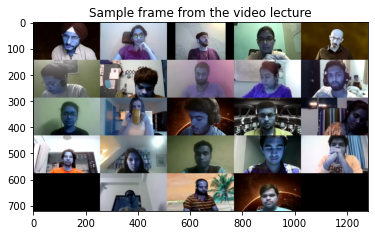

Analysis complete!


In [ ]:

video_path = '/content/gdrive/MyDrive/drowsiness/lecture-3.mp4'

cap = cv2.VideoCapture(video_path) 

count_faces = []
drowsy_scores = []
sample_rate_in_seconds = 20

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
sample_rate = cap.get(cv2.CAP_PROP_FPS)*sample_rate_in_seconds

faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml") 

for fno in range(0, total_frames, int(sample_rate)):
    cap.set(cv2.CAP_PROP_POS_FRAMES, fno)
    _, image = cap.read()

    if fno == 2000:
      plt.imshow(image)
      plt.title('Sample frame from the video lecture')
      plt.show()
    
    faces = faceCascade.detectMultiScale(image,scaleFactor=1.25, minNeighbors=3,minSize=(30, 30) )
    score  = []
    for (x, y, w, h) in faces:
        crop_img = image[y:y+h, x:x+w]
        crop_img =cv2.resize(cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY),(256,256)).reshape(256,256,1)
        crop_img = prep(crop_img)
        prediction = (new_model.predict_classes(crop_img.reshape(1,256,256,1)))
        score.append(prediction[0])
        
    if(len(faces) ==0):
        drowsy_scores.append(0)
    else:
        drowsy_scores.append(sum(score)/len(faces))
        
print("Analysis complete!")



Plotting the drowsiness scores as a function of time. This is done for the user to analyze and optimize content delivery.

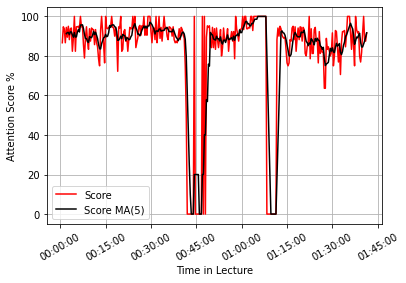

In [ ]:

def convert(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

srs = pd.Series(drowsy_scores)
new_idx = (srs.index.to_series()*sample_rate_in_seconds).apply(lambda x: convert(x))
srs.index = new_idx
srs = srs[1:]
srs.index = pd.to_datetime(srs.index,format='%H:%M:%S')
seclocator = mdates.SecondLocator()
minlocator = mdates.MinuteLocator()
fig, ax = plt.subplots()
ax.plot(srs[1:]*100,'red',label='Score')
ax.plot(srs[1:].rolling(5).mean()*100,'black',label='Score MA(5)')
ax.xaxis_date()
plt.ylabel('Attention Score %')
plt.xlabel('Time in Lecture')
ax.grid()
ax.legend(loc='lower left')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 30)

plt.show()

The clear drops we see in this graph are due to the breakout sessions

## Application 2: Real time drowsiness score using webcam.
Please make sure the computer is connected to only one screen and the video running software (zoom/google meet) is on top of all windows

Note: This following code will not run on google collab as there is no window to conect to. Download code to run locally.

In [ ]:


faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml") 

def get_live_drowsiness_score():
    
    image = pyscreenshot.grab()
    image = np.array(image)
    
    faces = faceCascade.detectMultiScale(image,scaleFactor=1.25, minNeighbors=3,minSize=(30, 30) )
    score  = []
    for (x, y, w, h) in faces:
        crop_img = image[y-(1*h):y+(2*h), x-(2*w):x+(2*w)]
        plt.imshow(image)
        plt.show()
        
        crop_img =cv2.resize(cv2.cvtColor(crop_img, cv2.COLOR_RGB2GRAY),(256,256)).reshape(1,256,256,1)

        prediction = (new_model.predict(crop_img))
        score.append(prediction[0][1])
        

        
        
    if(len(faces) ==0):
        #"No faces detected!"
        return 0
    else:  
        plt.imshow(image)
        plt.title("Captured Image")
        plt.show()
        #"Found faces"
        return sum(score)/len(faces)

Here we capture the live feed every 0.5 seconds. The counter was added to prevent an infinite loop.

In [ ]:
counter=0
while True:
    score=get_live_drowsiness_score()
    display(Javascript("""require(
    ["base/js/dialog"], 
    function(dialog) {
        dialog.modal({
            title: 'Hello instructor!',
            body: 'The average drowsiness score is: %s',
            buttons: {
                'K Thx Bye': {}
            }
        });
    }
    );""" % str(score)))
    counter+=1
    if(counter==10):
        break
    time.sleep(0.5)
    


Sample live video capture

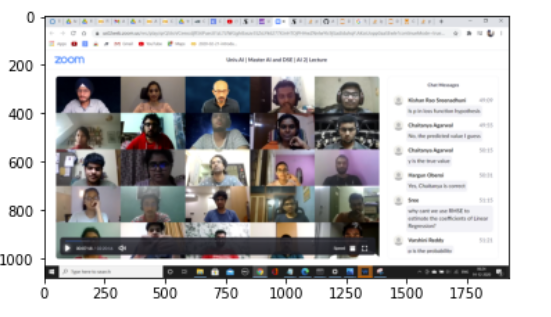

Sample pop-up

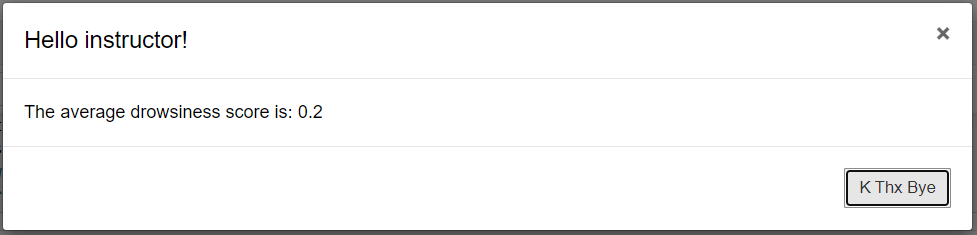

# Conclusion

In this project after training the CNN model for 20 epochs, it is able to recognize the attentiveness of the participants/students with fairly good accuracy.
From the saliency graphs we can see that the model is focusing on major facial features (eyes, mouth) to distinguish alert/drowsy state.

At the end of the lecture, instructor can view how the attentiveness of their students varied over a period of time, thereby helping them in structuring the content of lecture in an encaptivating manner.

Future work: This model can be plugged into any video call platforms like Zoom, Google meet etc. to provide live feedback of the session to the speaker by notifying the speaker when the attention of most of the audience drops.
